In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/outputs.csv")

In [20]:
df2 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/outputs_best_checkpoint.csv")

In [3]:
print(df.head())

             Timestamp  Predictions  ground_truth
0  2023-08-01T00:00:00     0.000002      0.000003
1  2023-08-01T00:01:00     0.000002      0.000003
2  2023-08-01T00:02:00     0.000002      0.000003
3  2023-08-01T00:03:00     0.000002      0.000003
4  2023-08-01T00:04:00     0.000003      0.000003


In [21]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format='%Y-%m-%dT%H:%M:%S')

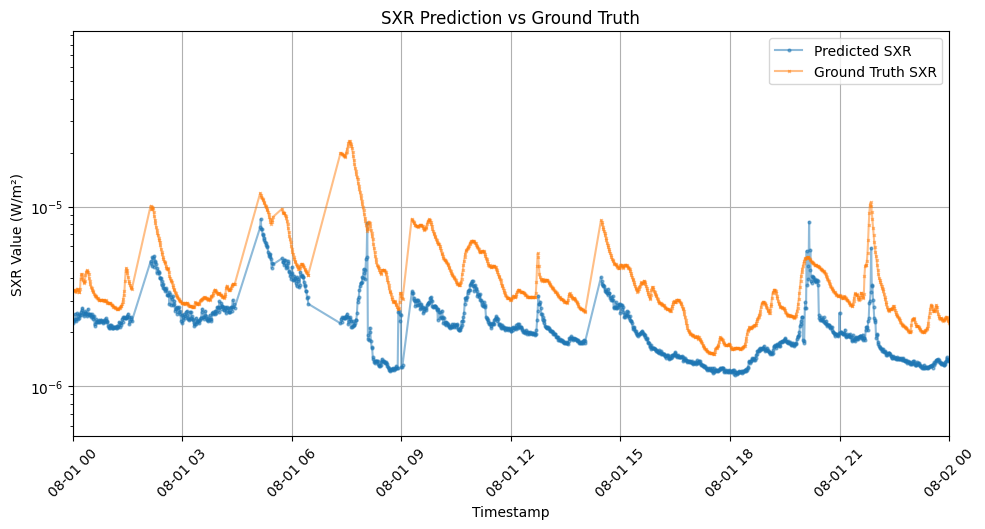

In [24]:
df = df.sort_values(by='Timestamp')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=2,alpha=.5)
#plt.plot(df2['Timestamp'], df2['Predictions'], label='Predicted SXR Best Checkpoint', marker='o',markersize=2,alpha=.5)
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-01T00:00:00"), pd.to_datetime("2023-08-2T00:00:00"))
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()